# Final Project
**CS283 Computer Vision, Harvard University, Fall 2019**

**Due Wednesday, Oct. 30, at 5:00pm**

Name: *(<font color=red>Haoran Chen</font>)*

---

In [11]:
pip install ipympl

The directory '/jupyteruser/50914127/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/50914127/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.


Note: you may need to restart the kernel to use updated packages.


In [140]:
# Import any required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import pickle
import csv

from scipy import signal
from scipy import misc

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

from scipy.optimize import nnls,minimize

# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters before specific plots.
plt.rcParams['figure.figsize'] = [5, 10]

## Recover Surface Normal with Known Lighting Direction

[[0.00784314 0.00784314 0.00784314 ... 0.00784314 0.00784314 0.00784314]
 [0.         0.         0.         ... 0.00784314 0.00784314 0.00784314]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[-0.1418 -0.1804 -0.9267]
 [ 0.1215 -0.2026 -0.9717]
 [-0.069  -0.0345 -0.838 ]
 [ 0.067  -0.0402 -0.9772]
 [-0.1627  0.122  -0.979 ]
 [ 0.      0.1194 -0.9648]
 [ 0.1478  0.1209 -0.9713]]
[0.91142429 1.0000099  0.70819525 0.96102488 0.99979629 0.9450954
 0.97988534]


<IPython.core.display.Javascript object>


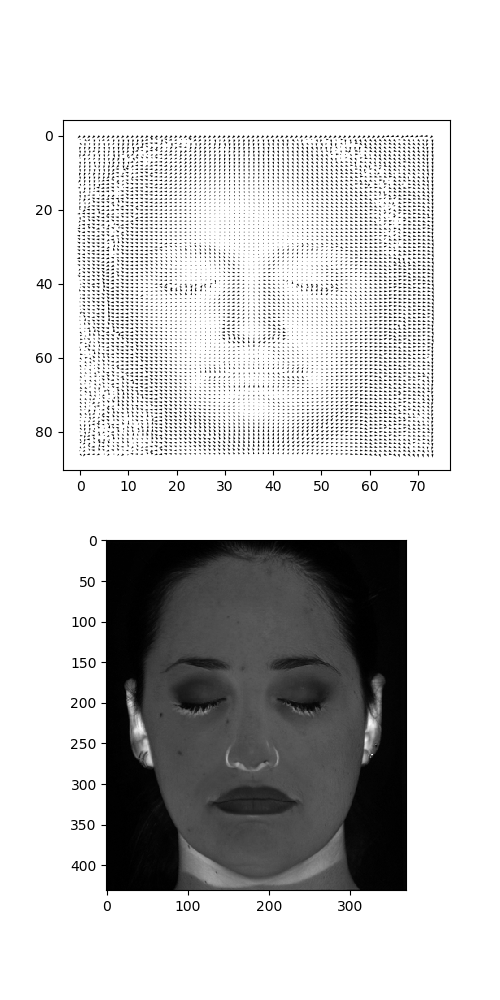

In [3]:
# TO DO: your code here
#S=np.genfromtxt('light_directions.txt',delimiter=",",dtype=float)
#S=S.transpose()

data = pickle.load(open('face/sources.pickle', 'rb'))
S=data['S']

#filename='cat/Image_01.png'
filename='face/female_01.tif'
im=cv2.imread(filename)
w=im.shape[0]
h=im.shape[1]

length=w*h

I=np.zeros((7,w*h))

for i in range(1,8):
    #filename='cat/Image_'+str(i).zfill(2)+'.png'
    filename='face/female_0'+str(i)+'.tif'
    im=cv2.imread(filename)
    im =np.float32(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)) / 255.0
    I[i-1,:]=im.flatten()

print(I)
print(S)

print(np.sum(S**2,axis=1))
    
b = np.linalg.lstsq(S, I, rcond=None)[0]

p = np.sqrt(np.sum(np.power(b, 2), 0)).reshape([w, h])

n = b.T.reshape([w, h, 3]) / np.tile(np.expand_dims(p, 2), [1, 1, 3])

plt.figure()
plt.subplot(211)
plt.quiver(n[::5,::5,0],n[::5,::5,1],cmap='gray')
plt.gca().invert_yaxis()
plt.subplot(212)
plt.imshow(p,cmap='gray')


## Recover surface nomral with Unknown lighting direction

In [137]:
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False
    
def lossfunc(solu,G):
    
    B=np.array([[solu[0]**2,0,solu[0]*solu[2]],
              [0,solu[0]**2,solu[0]*solu[3]],
              [0,0,solu[1]**2]])
    
    return np.linalg.norm(G-B)

def photometric(I):
    #First-pass SVD to recover the e and f vector described in paper
    U, D, V = np.linalg.svd(I2,full_matrices=False)

    e=V[0:3,:].T.reshape([w, h, 3])
    f=U[:,0:3]

    print('fsize',f.shape)

    #find the derivative of e
    kernalx=np.array([[0,-0.5,0],
                     [0,0,0],
                     [0,0.5,0]])

    kernaly=np.array([[0,0,0],
                     [-0.5,0,0.5],
                     [0,0,0]])

    e1=e[1:-1,1:-1,0].flatten()
    e2=e[1:-1,1:-1,1].flatten()
    e3=e[1:-1,1:-1,2].flatten()

    e1x=signal.correlate2d(e[:,:,0], kernalx, boundary='fill', mode='valid').flatten()
    e2x=signal.correlate2d(e[:,:,1], kernalx, boundary='fill', mode='valid').flatten()
    e3x=signal.correlate2d(e[:,:,2], kernalx, boundary='fill', mode='valid').flatten()

    e1y=signal.correlate2d(e[:,:,0], kernaly, boundary='fill', mode='valid').flatten()
    e2y=signal.correlate2d(e[:,:,1], kernaly, boundary='fill', mode='valid').flatten()
    e3y=signal.correlate2d(e[:,:,2], kernaly, boundary='fill', mode='valid').flatten()

    #constrcut the integrability contraint matrix

    a11=e2*e3x-e3*e2x
    a21=e2*e3y-e3*e2y
    a13=e1*e2x-e2*e1x
    a23=e1*e2y-e2*e1y
    a12=e1*e3x-e3*e1x
    a22=e1*e3y-e3*e1y

    A=np.concatenate((a11[:,np.newaxis],a12[:,np.newaxis],a13[:,np.newaxis],-a21[:,np.newaxis],-a22[:,np.newaxis],-a23[:,np.newaxis]),axis=1)

    #Find the null space of A which is the solution to Equation Ax=0

    U1,D1,V1=np.linalg.svd(A,full_matrices=False)

    #Reformat solution into 3x2 matrix, which is the first part of the cofactor matrix
    cofactor12=V1[4,:].reshape([3,2],order='F')

    #Assign the remaining value of the co-factor matrix by guessing.
    cofactor=np.concatenate((cofactor12,np.array([0.1,0.01,0.01])[:,np.newaxis]),axis=1)

    #Find inverse of the co-factor matrix
    Pns=np.linalg.lstsq(cofactor, np.eye(3), rcond=None)[0]

    #Rescale the P* to match the cofactor matrix
    Ps=Pns/((Pns[2,1]*Pns[1,2]-Pns[1,1]*Pns[2,2])/cofactor[0,0])

    #Calculate the inverse of P*
    Pstinv=np.linalg.lstsq(Ps.T, np.eye(3), rcond=None)[0]
    #Calcualte fT*f
    ff = np.einsum('ijn,jkn->ikn', f.T.reshape((3,1,I2.shape[0]),order='F'),f[:,:,np.newaxis].T)

    #Construct the unit intensity constraint matrix for b
    ffc=np.concatenate((ff[0,0,:,np.newaxis],2*ff[0,1,:,np.newaxis],2*ff[0,2,:,np.newaxis],ff[1,1,:,np.newaxis],2*ff[1,2,:,np.newaxis],ff[2,2,:,np.newaxis]),axis=1)

    #Solve for QTQ
    Q6= np.linalg.lstsq(ffc, np.ones(I2.shape[0]),rcond=None)[0]

    #Reconstruct QTQ as a symmertric matrix
    QTQ=np.array([[Q6[0],Q6[1],Q6[2]],
                [Q6[1],Q6[3],Q6[4]],
                [Q6[2],Q6[4],Q6[5]]])

    #QTQ is not positive definate due to numerical error introduced by noise, find the closest matrix to QTQ that is positive definate
    QTQ=nearestPD(QTQ)

    #Use cholesky decomposition to find the Qs
    Qs=np.linalg.cholesky(QTQ).T
    
    Qs=np.where(Qs < 0.05, 0, Qs)
    
    #Find the inverse of Qs
    Qsinv=np.linalg.lstsq(Qs, np.eye(3), rcond=None)[0]

    #Compute M
    M=Pstinv.dot(np.diag(D[0:3])).dot(Qsinv)

    x0=np.array([1000,1000,0,0])
    solu=minimize(lossfunc, x0,M.dot(M.T),method="SLSQP",options={'disp': True ,'eps' : 1e0})

    G=np.array([[solu.x[0],0,solu.x[2]],
              [0,solu.x[0],solu.x[3]],
              [0,0,solu.x[1]]])
    
    R=np.linalg.lstsq(G.T, M, rcond=None)[0]
    Q=R.dot(Qs)
    P=G.dot(Ps)

    b_su=np.dot(P,V[0:3,:])
    s_su=np.dot(Q,U[:,0:3].T).T
    s_su=s_su/(np.sqrt(np.sum(np.power(s_su,2),1))[:,np.newaxis])

    p_su = np.sqrt(np.sum(np.power(b_su, 2), 0)).reshape([w, h])
    n_su = b_su.T.reshape([w, h, 3]) / np.tile(np.expand_dims(p_su, 2), [1, 1, 3])

    return p_su,n_su,s_su

fsize (7, 3)
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 71548634.7837727
            Iterations: 93
            Function evaluations: 1385
            Gradient evaluations: 93


<IPython.core.display.Javascript object>


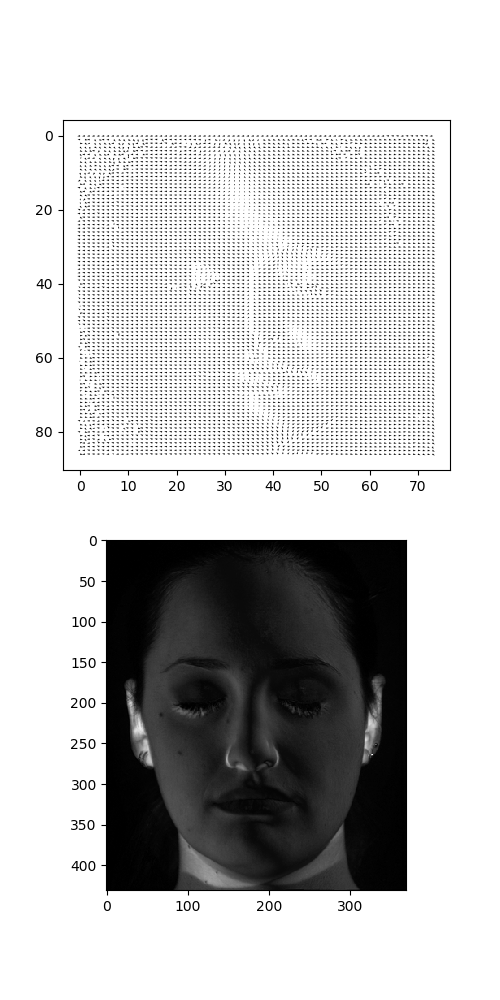

In [139]:

#filename='cat/Image_01.png'
filename='face/female_01.tif'
im=cv2.imread(filename)
w=im.shape[0]
h=im.shape[1]

I2=np.zeros((7,w*h))

for i in range(1,8):
        #filename='cat/Image_'+str(i).zfill(2)+'.png'
        filename='face/female_0'+str(i)+'.tif'
        im=cv2.imread(filename)
        im =np.float32(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)) / 255.0
        I2[i-1,:]=im.flatten()

p_su,n_su,s_su=photometric(I2)

plt.figure()
plt.subplot(211)
plt.quiver(n_su[::5,::5,0],n_su[::5,::5,1],cmap='gray')
plt.gca().invert_yaxis()


plt.subplot(212)
plt.imshow(p_su,cmap='gray')


## Understand the R' ambiguity

(3, 1000)
(3, 1000)
[[-11.49131665 -93.91067615 -23.34785677]
 [  1.19427788  26.61188163 -59.22555498]
 [103.33222197  -0.19500903   0.82955177]]
[[ -1.36038303 -10.07768296   0.11416799]
 [ -0.19768567   0.34672748   0.93301698]
 [  0.60231469  -0.03828605   0.23196454]]
[[ 1.03423370e+02 -3.11876072e+00 -4.07061124e-01]
 [-3.11876072e+00  1.02982026e+00  8.40830486e-02]
 [-4.07061124e-01  8.40830486e-02  4.18056356e-01]]


<IPython.core.display.Javascript object>


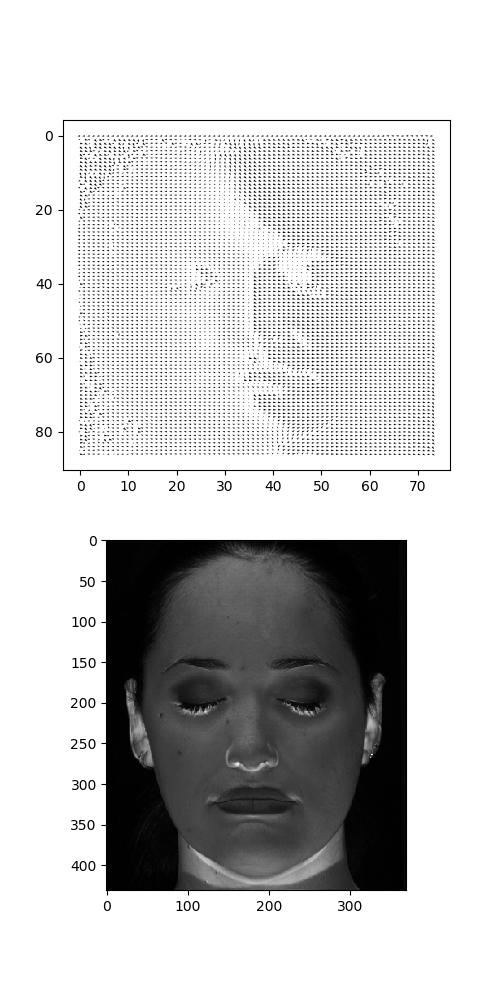

In [134]:
P_truth=np.linalg.lstsq(V[0:3,9000:10000].T, b[:,9000:10000].T, rcond=None)[0].T

print(V[0:3,9000:10000].shape)
print(b[0:3,9000:10000].shape)

print(P_truth)
R_prime=np.linalg.lstsq(P.T, P_truth, rcond=None)[0].T

print(R_prime)
print(R_prime.dot(R_prime.T))
b_su_c = np.dot(R_prime,b_su)
p_su_c = np.sqrt(np.sum(np.power(b_su_c, 2), 0)).reshape([w, h])
n_su_c = b_su.T.reshape([w, h, 3]) / np.tile(np.expand_dims(p_su, 2), [1, 1, 3])

plt.figure()
plt.subplot(211)
plt.quiver(n_su_c[::5,::5,0],n_su_c[::5,::5,1],cmap='gray')
plt.gca().invert_yaxis()


plt.subplot(212)
plt.imshow(p_su_c,cmap='gray')

The function <tt> integrate_frankot()</tt> below can be used to recover a surface $z(x,y)$ from your
surface normals $\hat{n}(x,y)$. Run the two cells below to generate and display your surface, and then modify the second cell to include two views of your surface.

In [135]:
def integrate_frankot(N):
    
    """
    integrate_frankot(N) takes an PxQx3 field of normal vectors (the third
    dimension is [x y z]) and returns a PxQ array corresponding to the
    depth of the surface, with the mean depth equal to zero.
    
    Reference: Frankot, R. and Chellapa, R. (1988) "A Method for Enforcing
    Integrability in Shape from Shading Algorithms."  IEEE Trans. Pattern
    Anal. Mach. Intell. 10(4):439-451.

    Args:
        N: PxQx3 field of normal vectors

    Returns:
        PxQ array corresponding to the depth of the surface, with the mean depth equal to zero

    Todd Zickler, November 2001; updated for CS283 October. 2019.

    """

    h, w = N[:, :, 0].shape

    # complain if P or Q are too big
    if (h > 640) | (w > 512):
        print('Input array too big.  Choose a smaller window.')

    # pad the array to 512x512
    nrows = 700
    ncols = 700
    
    # get surface slopes from normals; ignore points where normal is [0 0 0]
    x_sample = 1
    y_sample = 1
    zx = -x_sample * (np.sum(N, 2) != 0) * N[:, :, 0] / (N[:, :, 2] + (N[:, :, 2] == 0))
    zy = -y_sample * (np.sum(N, 2) != 0) * N[:, :, 1] / (N[:, :, 2] + (N[:, :, 2] == 0))

    Zx_sq = np.fft.fft2(zx, s=[nrows, ncols])
    Zy_sq = np.fft.fft2(zy, s=[nrows, ncols])
    h2 = nrows
    w2 = ncols
    
    Zx = Zx_sq.flatten('C')
    Zy = Zy_sq.flatten('C')
    
    # compute repeated frequency vectors (See Chellapa paper)
    h2_vec = np.expand_dims(np.concatenate((np.arange(0, h2/2 + 1),np.arange(-h2/2+1, 0))), 1)
    w2_vec = np.expand_dims(np.concatenate((np.arange(0, w2/2 + 1),np.arange(-w2/2+1, 0))), 1)
    
    Wx = np.squeeze(np.tile(2 * np.pi / h2 * h2_vec, [w2, 1]))
    Wy = np.squeeze(np.kron(2 * np.pi / w2 * w2_vec, np.ones((h2, 1))))
    
    # compute transform of least squares closest integrable surface
    Wx[0] = 1
    Wy[0] = 1
    # remove first column because it's all zeros (then add C(0)=0)
    C = (-1j * Wx * Zx - 1j * Wy * Zy) / (np.power(Wx, 2) + np.power(Wy, 2))
  
    # set DC component of C
    C[0] = 0
    
    # invert transform to get depth of integrable surface
    Z = np.real(np.fft.ifft2(np.reshape(C, [h2, w2], 'C')))
    
    # crop Z to original input shape
    Z = Z[:h, :w]
    
    return Z

<IPython.core.display.Javascript object>


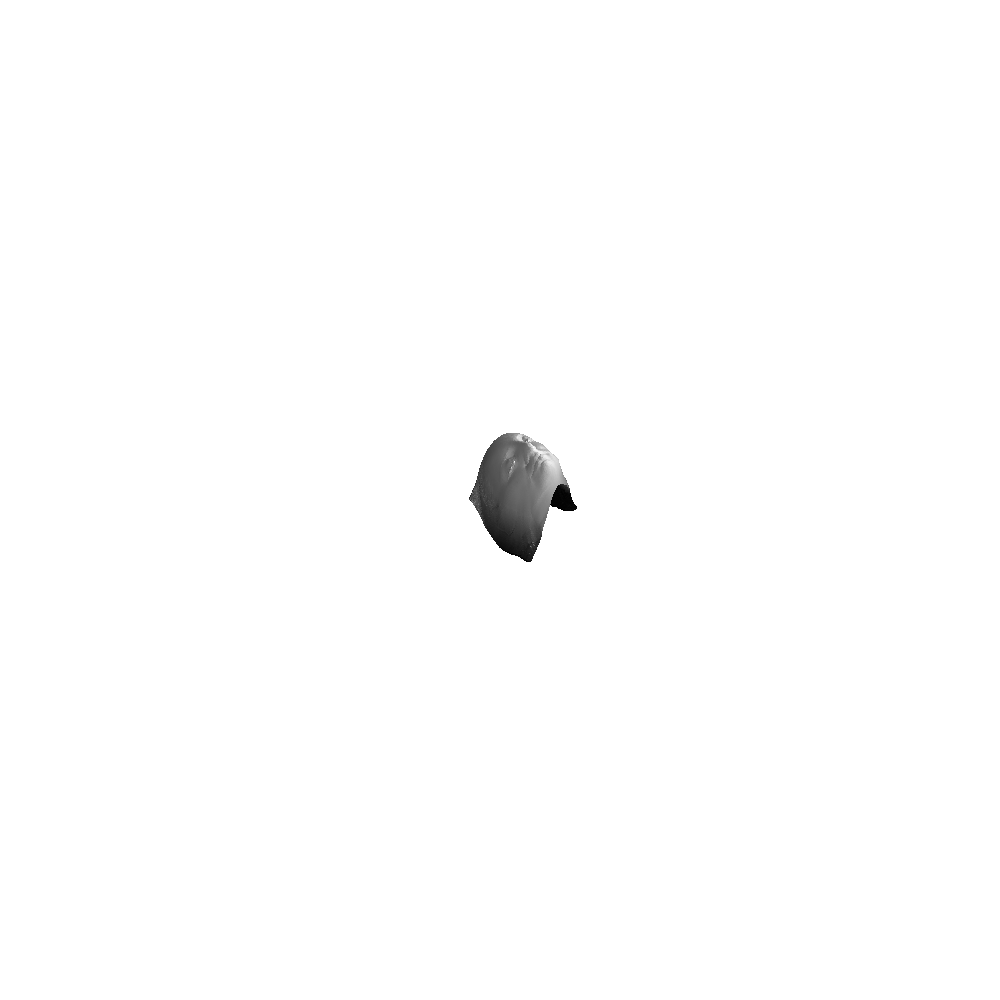

(431, 369)
(431, 369)
(431, 369)
1990.9417752125241


In [136]:
# Run the cell below to plot Z as a surface:


Z = integrate_frankot(n_su)

h, w = n_su[:, :, 0].shape

# Define a meshgrid of X and Y coordinates
X,Y = np.meshgrid(np.arange(w), np.arange(h))

# Create a figure and define its axes
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.axis('off')

# Define the viewing angle
ax.view_init(elev=240, azim=-50)

# Define a light source direction
ls = LightSource(azdeg=260, altdeg=125)
surf_illum = ls.shade(-Z, cmap=cm.gist_yarg)

print(X.shape)
print(Y.shape)
print(Z.shape)

# Shade data, creating an rgb array.
surf = ax.plot_surface(X, Y, -Z, rstride=2, cstride=2, linewidth=0,
                       antialiased=False, facecolors=surf_illum)#color='gray')
# Resolution of rendering and time needed to render will depend on rstride and cstride

# Create cubic bounding box to simulate equal aspect ratio
# https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')
print(Z.max()-Z.min())
    
# Show the plot
plt.show()

## Hints and Information

- The following code demonstrates one way to use the <tt>matplotlib.pyplot.quiver</tt> function.

```python
# vect_x is an HxW array of x-components
# vect_y is an HxW array of y-components
plt.figure()
plt.quiver(vect_x,vect_y,cmap='gray')
plt.gca().invert_yaxis();
plt.axis('image');
plt.axis('off')';

```

Note that the vector components should be displayed at a suitable resolution.  For example, the figure below shows the $x$-$y$ components of a field of surface normals at three different resolutions. The plot in the middle provides the best summary of the surface shape.  The resolution can be adjusted by plotting only every
$n^\mathrm{th}$ element as in <tt>plt.quiver(vect_x[::n, ::n], vect_y[::n, ::n])</tt>.

<img src="pset7/img/babys_normals.png" width="800">

- When computing the output radiance from a field of surface normals $\hat{n}(x,y)$ illuminated from direction $\hat{s}$, clip negative values using $L=\max(0,\hat{n}\cdot\hat{s})$.

- We are commonly faced with a situation in which we need to evaluate the integral over the hemisphere of the function $\cos\theta$, where $0\le\theta\pi$ is the angular distance between the radial line through a point on the hemisphere and the radial line through its apex.

\begin{equation}
\int_\Omega \cos\theta d\omega
\end{equation}

The first step is to define a parameterization of the hemisphere using spherical coordinates, and the second is to write an element of the solid angle $d\omega$ in terms of this parameterization. As shown in almost any introductory calculus book (and Forsyth & Ponce), we can write this integral as

\begin{equation}
\int_0^{2\pi} \int_0^{\pi/2} \cos\theta\sin\theta d\theta d\phi,
\end{equation}

which is straightforward to evaluate using the appropriate trigonometric identity. 